In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Data Import and Pre-processing

In [75]:
batteries_pi=pd.read_csv('C:/Users/apoor/Desktop/Module 3/Industry Practicum/Data/batteries_pi_Final.csv')
batteries_pi=batteries_pi.loc[batteries_pi["STORE_NUMBER"] != 1020]
print(batteries_pi.shape)
print(batteries_pi.SKU_NUMBER.nunique())

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,85) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(6253303, 88)
1603


In [76]:
batteries_pi.drop([ 'PLATFORM_CLUSTER_NAME','POP_EST_CY', 'POP_DENSITY_CY', 'PCT_WHITE', 'AGE',
       'PCT_COLLEGE', 'PCT_BLUE_COLLAR','PART_TYPE','SKU_EXISTENCE_CY','SKU_STORE_PDQ_CY', 'TOTAL_VIO_CY','UNADJUSTED_TOTAL_VIO_CY',
       'LOST_QTY_CY',  'SS_SALES_CY','AVG_CLUSTER_UNIT_SALES_CY','AVG_CLUSTER_LOST_SALES_CY',
       'VIO_COMPARED_TO_CLUSTER_CY','ADJUSTED_AVG_CLUSTER_SALES_CY','AVG_CLUSTER_TOTAL_SALES_CY', 'SALES_SIGNAL_CY',
       'FAILURE_SALES_CY','LIFECYCLE_CY', 'ADJUSTED_LIFECYCLE_CY','PCT_OF_LIFECYCLE_REMAINING',
        'ADJ_AVG_CLUSTER_LOST_SALES_CY', 'LIFECYCLE_PRE_PEAK_POST','ADJ_AVG_CLUSTER_TOTAL_SALES_CY',
        'SOLD_SINCE_MAXI', 'cy_unit_sales','cy_gross_sales', 'cy_sales_cost',
       'other_unit_sales', 'other_gross_sales', 'other_sales_cost','PROJECTED_GROWTH_PCT_CY', 
        'OTHER_UNIT_PLS_LOST_SALES_PPY','OTHER_UNIT_PLS_LOST_SALES_PY', 'OTHER_UNIT_PLS_LOST_SALES_CY', 'LOOKUP_CNT_CY',
       'WEIGHTED_LOOKUP_CNT_CY', 'CY_PERIODS_IN_STOCK', 'WAIT_TIME_BUCKET',
       'MPOG_ID', 'DATA_CLASSIFICATION', 'cy_qty_sold_transfer',
       'cy_qty_sold_on_hand', 'ON_HAND','cy_ts_forecast', 'PROJECTED_GROWTH_PCT_PY','ROAD_QUALITY_INDEX','LOST_QTY_PY',
            'MEDIAN_HOUSEHOLD_INCOME'], axis=1, inplace=True)

In [77]:
batteries_pi.shape

(6253303, 36)

In [78]:
batteries_pi.dtypes

SKU_NUMBER                          int64
STORE_NUMBER                        int64
APPLICATION_COUNT                   int64
ESTABLISHMENTS                    float64
SKU_EXISTENCE_PY                    int64
SKU_STORE_PDQ_PY                    int64
TOTAL_VIO_PY                      float64
UNADJUSTED_TOTAL_VIO_PY           float64
SS_SALES_PY                       float64
AVG_CLUSTER_UNIT_SALES_PY         float64
AVG_CLUSTER_LOST_SALES_PY         float64
VIO_COMPARED_TO_CLUSTER_PY        float64
ADJUSTED_AVG_CLUSTER_SALES_PY     float64
QTY_SOLD_PPY                      float64
QTY_SOLD_PY                       float64
QTY_SOLD_CY                       float64
AVG_CLUSTER_TOTAL_SALES_PY        float64
SALES_SIGNAL_PY                   float64
FAILURE_SALES_PY                  float64
LIFECYCLE_PY                      float64
ADJUSTED_LIFECYCLE_PY             float64
ADJ_AVG_CLUSTER_LOST_SALES_PY     float64
ADJ_AVG_CLUSTER_TOTAL_SALES_PY    float64
py_unit_sales                     

In [79]:
batteries_pi.isnull().values.any()

True

In [80]:
batteries_pi = batteries_pi.fillna(0)

In [81]:
stats2 = batteries_pi.groupby(['SKU_NUMBER'])['QTY_SOLD_PY'].agg(['sum', 'mean', 'max'])
print(stats2)

                sum       mean    max
SKU_NUMBER                           
2020000      3166.0   0.811587   47.0
2020041         2.0   0.000513    1.0
2030000      8762.0   2.246091   33.0
2040000     41402.0  10.613176   47.0
2040002         0.0   0.000000    0.0
...             ...        ...    ...
99984959        0.0   0.000000    0.0
99991365        0.0   0.000000    0.0
99996785    47324.0  12.131248   57.0
99996787     2656.0   0.680851    8.0
99996789     7212.0   1.848757  118.0

[1603 rows x 3 columns]


In [82]:
stats2_0=stats2.loc[((stats2["sum"] <= 1000) | (stats2["max"] <= 100)) , ["sum"]]
list_skus_0 = stats2_0.index.unique().tolist()
n_final_0 = len(list_skus_0)
print(n_final_0)

1519


In [83]:
list_skus = batteries_pi.SKU_NUMBER.unique().tolist()
#Excluding the SKUs that have less or equal than 24 qty as total sales
final_list= list(set(list_skus) - set(list_skus_0))
len(final_list)

84

### Filtering for Pesky SKUs

In [84]:
# USING Tukey’s box plot method for Pesky identification
def tukeys_method(df, variable):
    #Excluding the SKUs that have 0 as total sales
    stats2 = df.groupby(['SKU_NUMBER'])[variable].agg(['sum'])
    stats2_0=stats2.loc[stats2["sum"] == 0, ["sum"]]
    list_skus_0 = stats2_0.index.unique().tolist()
    n_final_0 = len(list_skus_0)
    
    #Takes two parameters: dataframe & variable of interest as string
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3-q1
    inner_fence = 1.5*iqr
    outer_fence = 3*iqr
    
    #inner fence lower and upper end
    inner_fence_le = q1-inner_fence
    inner_fence_ue = q3+inner_fence
    
    #outer fence lower and upper end
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    
    outliers_prob = []
    outliers_poss = []
    for index, x in enumerate(df[variable]):
        if x < outer_fence_le or x > outer_fence_ue:
            outliers_prob.append(index)
    for index, x in enumerate(df[variable]):
        if x < inner_fence_le or x > inner_fence_ue:
            outliers_poss.append(index)
    
    n_prob_outliers=len(outliers_prob)
    n_poss_outliers=len(outliers_poss)
    if n_final_0>0:
        n_prob_outliers=0
    return n_prob_outliers, n_poss_outliers

In [102]:
# Calculating the number of Pesky SKUs using the Tukey’s box plot, extended to the log-IQ method (highly skewed distribution)
list_skus = batteries_pi.SKU_NUMBER.unique().tolist()
n=0
pesky_skus_t=[]
for sku in final_list:
    print("SKU # processing:",final_list.index(sku))
    batteries_pi_x=batteries_pi.loc[batteries_pi["SKU_NUMBER"] == sku, ["SKU_NUMBER", "QTY_SOLD_CY"]]
    batteries_pi_x['QTY_SOLD_CY_1'] = batteries_pi_x['QTY_SOLD_CY']+1
    log_QTY_SOLD_CY = np.log(batteries_pi_x['QTY_SOLD_CY_1']+0.0001)
    batteries_pi_x['LOG_QTY_SOLD_CY_1'] = log_QTY_SOLD_CY
    n_prob_o_x, n_poss_o_x = tukeys_method(batteries_pi_x, "LOG_QTY_SOLD_CY_1")
    if n_prob_o_x>0:
        n=n+1
        pesky_skus_t.append(sku)


print(round((n*100/len(final_list)),3), "% are Pesky SKUs using the Tukey’s box plot method")

SKU # processing: 0
SKU # processing: 1
SKU # processing: 2
SKU # processing: 3
SKU # processing: 4
SKU # processing: 5
SKU # processing: 6
SKU # processing: 7
SKU # processing: 8
SKU # processing: 9
SKU # processing: 10
SKU # processing: 11
SKU # processing: 12
SKU # processing: 13
SKU # processing: 14
SKU # processing: 15
SKU # processing: 16
SKU # processing: 17
SKU # processing: 18
SKU # processing: 19
SKU # processing: 20
SKU # processing: 21
SKU # processing: 22
SKU # processing: 23
SKU # processing: 24
SKU # processing: 25
SKU # processing: 26
SKU # processing: 27
SKU # processing: 28
SKU # processing: 29
SKU # processing: 30
SKU # processing: 31
SKU # processing: 32
SKU # processing: 33
SKU # processing: 34
SKU # processing: 35
SKU # processing: 36
SKU # processing: 37
SKU # processing: 38
SKU # processing: 39
SKU # processing: 40
SKU # processing: 41
SKU # processing: 42
SKU # processing: 43
SKU # processing: 44
SKU # processing: 45
SKU # processing: 46
SKU # processing:

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


 47
SKU # processing: 48
SKU # processing: 49
SKU # processing: 50
SKU # processing: 51
SKU # processing: 52
SKU # processing: 53
SKU # processing: 54
SKU # processing: 55
SKU # processing: 56
SKU # processing: 57
SKU # processing: 58
SKU # processing: 59
SKU # processing: 60
SKU # processing: 61
SKU # processing: 62
SKU # processing: 63
SKU # processing: 64
SKU # processing: 65
SKU # processing: 66
SKU # processing: 67
SKU # processing: 68
SKU # processing: 69
SKU # processing: 70
SKU # processing: 71
SKU # processing: 72
SKU # processing: 73
SKU # processing: 74
SKU # processing: 75
SKU # processing: 76
SKU # processing: 77
SKU # processing: 78
SKU # processing: 79
SKU # processing: 80
SKU # processing: 81
SKU # processing: 82
SKU # processing: 83
78.571 % are Pesky SKUs using the Tukey’s box plot method


In [103]:
batteries_pi = batteries_pi[(batteries_pi['SKU_NUMBER'].isin(pesky_skus_t))]
len(batteries_pi.SKU_NUMBER.unique())

66

In [104]:
batteries_pi.shape

(185254, 36)

In [105]:
batteries_pi = batteries_pi[(batteries_pi['QTY_SOLD_PY']!=0) & (batteries_pi['QTY_SOLD_PPY']!=0)]

In [106]:
batteries_pi.shape

(185254, 36)

In [119]:
batteries_pi =batteries_pi[(batteries_pi['QTY_SOLD_PY']<1400)]

In [120]:
batteries_pi[['QTY_SOLD_CY','QTY_SOLD_PY']].sort_values(['QTY_SOLD_PY'], ascending = False)

,QTY_SOLD_CY,QTY_SOLD_PY
633847,1322.0,1344.0
2211489,-25.0,946.0
501627,338.0,867.0
5003444,-20.0,708.0
197724,568.0,687.0
...,...,...
2860090,0.0,-3.0
1812498,8.0,-3.0
5584216,3.0,-3.0
1744214,2.0,-3.0


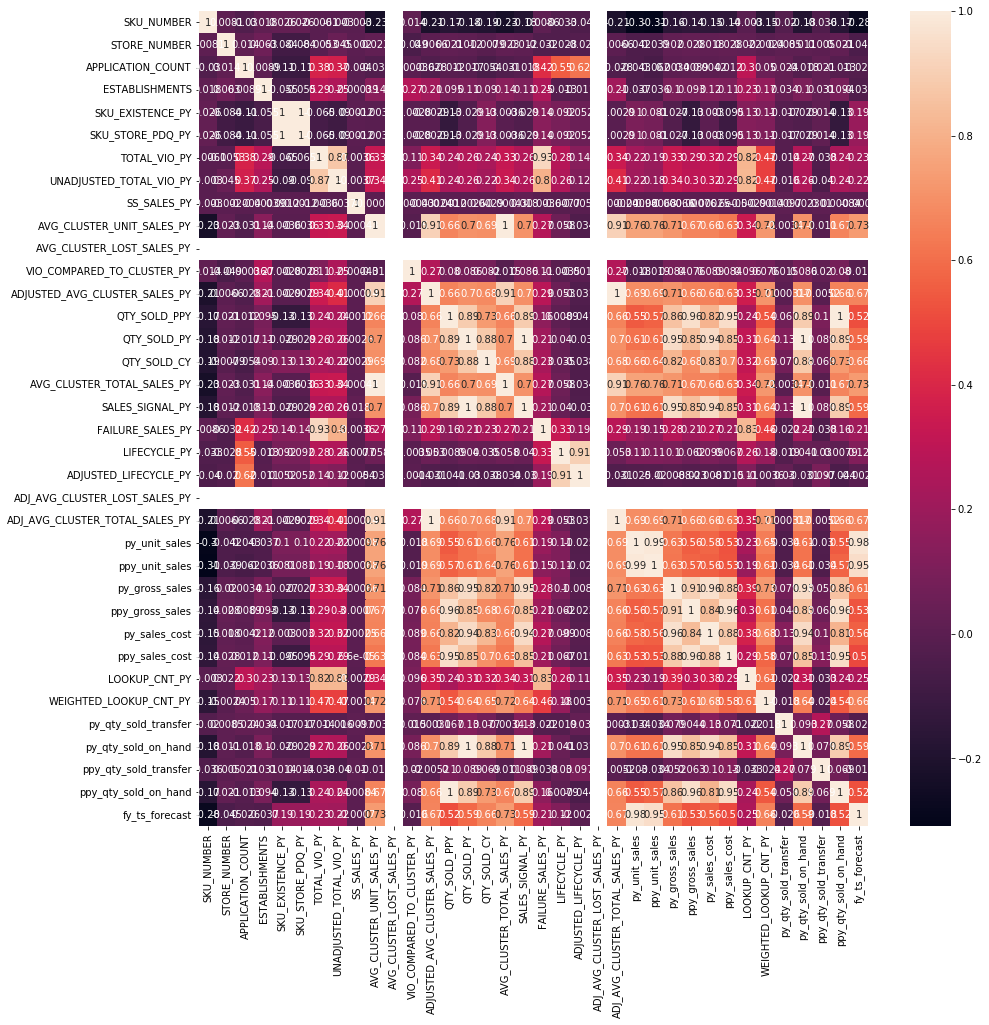

In [91]:
plt.figure(figsize=(15,15))
corrMatrix = batteries_pi.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [59]:
#Correlation with output variable
cor_target = abs(corrMatrix["QTY_SOLD_CY"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

AVG_CLUSTER_UNIT_SALES_PY         0.692316
ADJUSTED_AVG_CLUSTER_SALES_PY     0.686603
QTY_SOLD_PPY                      0.729758
QTY_SOLD_PY                       0.876612
QTY_SOLD_CY                       1.000000
AVG_CLUSTER_TOTAL_SALES_PY        0.692316
SALES_SIGNAL_PY                   0.876514
ADJ_AVG_CLUSTER_TOTAL_SALES_PY    0.686603
py_unit_sales                     0.663984
ppy_unit_sales                    0.647988
py_gross_sales                    0.824801
ppy_gross_sales                   0.683070
py_sales_cost                     0.825204
ppy_sales_cost                    0.698442
WEIGHTED_LOOKUP_CNT_PY            0.661084
py_qty_sold_on_hand               0.877439
ppy_qty_sold_on_hand              0.729503
fy_ts_forecast                    0.666442
Name: QTY_SOLD_CY, dtype: float64

### Data Partition and Modeling

In [121]:
X = batteries_pi.loc[:, (batteries_pi.columns != 'QTY_SOLD_CY')].values
y = batteries_pi['QTY_SOLD_CY'].values

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [123]:
print(f"No. of training examples: {X_train.shape[0]}")
print(f"No. of testing examples: {X_val.shape[0]}")
print(f"No. of testing examples: {X_test.shape[0]}")

No. of training examples: 111151
No. of testing examples: 37051
No. of testing examples: 37051


In [124]:
high_sales = []
low_sales = []

for element in y_train:
    if element > 100:
        high_sales.append(element)
    else:
        low_sales.append(element)

print("% of SKUs with high sales in training set:",len(high_sales)/len(low_sales)*100)
print("No of SKUs with high sales in training set:",len(high_sales))

% of SKUs with high sales in training set: 2.5255273814025996
No of SKUs with high sales in training set: 2738


In [125]:
high_sales_test = []
low_sales_test = []

for element in y_test:
    if element > 100:
        high_sales_test.append(element)
    else:
        low_sales_test.append(element)

print("% of SKUs with high sales in test set:",len(high_sales_test)/len(low_sales_test)*100)
print("No. of SKUs with high sales in test set:",len(high_sales_test))

% of SKUs with high sales in test set: 2.5122430346125117
No. of SKUs with high sales in test set: 908


### Linear Regression

In [126]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [127]:
y_pred = regressor.predict(X_test)

In [128]:
y_pred_1 = regressor.predict(X_val)

In [129]:
#Validation set metrics
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred_1))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred_1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred_1)))
print('R-Squared value:', metrics.r2_score(y_val, y_pred_1))

Mean Absolute Error: 6.514335810763301
Mean Squared Error: 134.90927905120284
Root Mean Squared Error: 11.615045374478864
R-Squared value: 0.8438354106288716


In [130]:
#Test Set metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-Squared value:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 6.517045028590521
Mean Squared Error: 118.6679146199738
Root Mean Squared Error: 10.893480372221441
R-Squared value: 0.8519388551763926


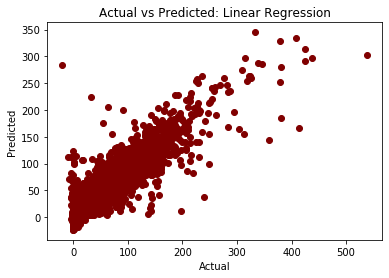

In [131]:
plt.scatter(y_test, y_pred, color = "maroon")
#g=plt.plot(y_test - y_pred,marker='o',linestyle='')
#plt.plot(X_train, regressor.predict(X_train), color = "green")
plt.title("Actual vs Predicted: Linear Regression")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

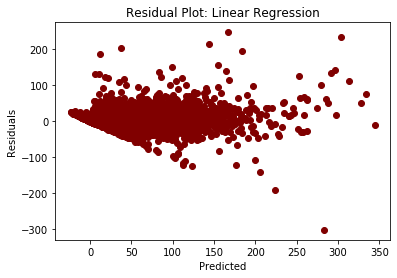

In [133]:
df_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_test['Residuals'] = df_test['Actual']-df_test['Predicted']
plt.scatter(df_test['Predicted'], df_test['Residuals'], color = "maroon")
plt.title("Residual Plot: Linear Regression")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

### Random Forest

In [134]:
from sklearn.ensemble import RandomForestRegressor


# Initializing the Random Forest Regression model with 10 decision trees
model1 = RandomForestRegressor(n_estimators = 20, random_state = 0)

# Fitting the Random Forest Regression model to the data
model1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [135]:
y_pred_RF_val = model1.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_val, y_pred_RF_val)))
print("R-Squared: ", metrics.r2_score(y_val, y_pred_RF_val))

RMSE:  11.429844417949496
R-Squared:  0.8487757707006618


In [136]:
y_pred_RF = model1.predict(X_test)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print("R-Squared: ", metrics.r2_score(y_test, y_pred_RF))

RMSE:  9.660530145380529
R-Squared:  0.8835579848644717


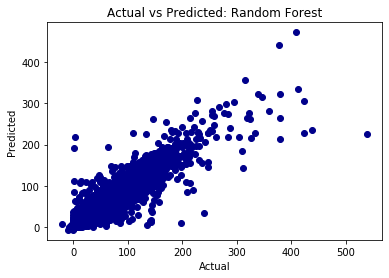

In [137]:
plt.scatter(y_test, y_pred_RF, color = "darkblue")
#g=plt.plot(y_test - y_pred,marker='o',linestyle='')
#plt.plot(X_train, regressor.predict(X_train), color = "green")
plt.title("Actual vs Predicted: Random Forest")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [138]:
model2 = RandomForestRegressor(n_estimators = 80, max_depth=20, max_features=8, random_state = 0)
model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=80, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [139]:
y_pred_RF_val = model2.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_val, y_pred_RF_val)))
print("R-Squared: ", metrics.r2_score(y_val, y_pred_RF_val))

RMSE:  11.212896619083889
R-Squared:  0.8544620081321591


In [140]:
y_pred_RF = model2.predict(X_test)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print("R-Squared: ", metrics.r2_score(y_test, y_pred_RF))

RMSE:  9.291014690509416
R-Squared:  0.8922954411758592


In [141]:
model3 = RandomForestRegressor(n_estimators = 110, max_depth=20, max_features=8, random_state = 0)
model3.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [142]:
y_pred_RF_val = model3.predict(X_val)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_val, y_pred_RF_val)))
print("R-Squared: ", metrics.r2_score(y_val, y_pred_RF_val))

RMSE:  11.265526122702937
R-Squared:  0.8530925907042846


In [143]:
y_pred_RF = model3.predict(X_test)
print("RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_pred_RF)))
print("R-Squared: ", metrics.r2_score(y_test, y_pred_RF))

RMSE:  9.269464441234984
R-Squared:  0.892794497167229


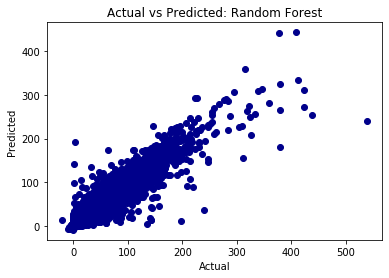

In [144]:
plt.scatter(y_test, y_pred_RF, color = "darkblue")
#g=plt.plot(y_test - y_pred,marker='o',linestyle='')
#plt.plot(X_train, regressor.predict(X_train), color = "green")
plt.title("Actual vs Predicted: Random Forest")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

### Lasso

In [145]:
# Lasso Model

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from math import sqrt

reg = Lasso(alpha=0.05)
reg.fit(X_train, y_train)

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
rmse_t = sqrt(mse_train)
print('RMSE training set: %f' % rmse_t)

# Validation data
pred = reg.predict(X_val)
mse_val =mean_squared_error(y_val, pred)
rmse_val = sqrt(mse_val)
print('RMSE validation set: %f' % rmse_val)

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
rmse_test= sqrt(mse_test)
print('RMSE Test set: %f' % rmse_test)

RMSE training set: 11.481038
RMSE validation set: 11.614906
RMSE Test set: 10.897756


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7339478.215821058, tolerance: 9192.76072387473
  positive)


In [146]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
import warnings
warnings.filterwarnings("ignore")


cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model = LassoCV(cv=cv, alphas=np.arange(0, 1, 0.01), n_jobs=-1, random_state=1)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)

alpha: 0.010000


In [147]:
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

# Training data
pred_train = lasso_best.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
rmse_t = sqrt(mse_train)
print('RMSE training set: %f' % rmse_t)

# Validation data
pred = lasso_best.predict(X_val)
mse_val =mean_squared_error(y_val, pred)
rmse_val = sqrt(mse_val)
print('RMSE validation set: %f' % rmse_val)

# Test data
pred = lasso_best.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
rmse_test= sqrt(mse_test)
print('RMSE Test set: %f' % rmse_test)

RMSE training set: 11.475265
RMSE validation set: 11.614112
RMSE Test set: 10.893360


### Feature Importance

In [148]:
feature_names = batteries_pi.loc[:, (batteries_pi.columns != 'QTY_SOLD_CY')].columns

<BarContainer object of 35 artists>

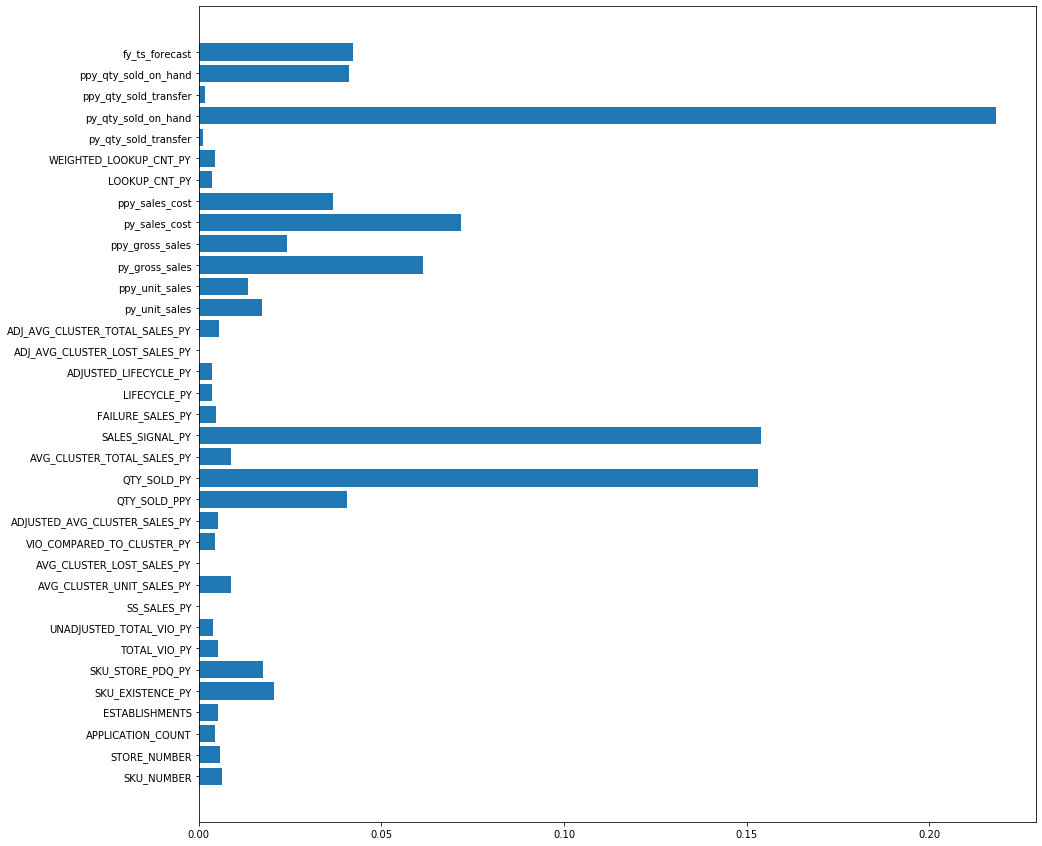

In [150]:
from matplotlib import pyplot

importance = model3.feature_importances_

plt.figure(figsize=(15,15))
plt.barh(feature_names, importance)